<a href="https://colab.research.google.com/github/VladimirBartunek/Edinburgh_Bikesharing_Pandas/blob/main/Edinburgh_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import datetime as dt
from shapely.geometry import Point, Polygon
import matplotlib.image as mpimg
pd.options.mode.chained_assignment = None
!pip install --upgrade geopandas
import geopandas as gpd

!pip install pymysql

student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
engeto_data_conn = sqlalchemy.create_engine(student_conn_string)

     |████████████████████████████████| 1.0MB 7.6MB/s 
     |████████████████████████████████| 6.5MB 18.8MB/s 
     |████████████████████████████████| 15.3MB 193kB/s 
     |████████████████████████████████| 92kB 11.5MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
     |████████████████████████████████| 51kB 4.5MB/s 


# **Obsah:**
**1. Očištění dat**

**2. Zjištění aktivity jednotlivých stanic**

**3. Přeplněné/prázdné stanice**

**4. Vzdálenost mezi stanicemi**

**5. Vývoj poptávky v čase**

**6. Příčiny výkyvů poptávky**

**7. Odlehlé hodnoty**

**8. Vliv rozmístění stanic na poptávku**

**9. Návrhy na vylepšení služby a eliminace potenciálních problémů**

**10. Závěr**

In [ ]:
#Import záznamů o vypůjčení
query = 'select * from edinburgh_bikes'
eb = pd.read_sql(query, engeto_data_conn)
eb.head(5)

,index,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


# **1. Očištění dat**

In [ ]:
#Zjišťuji, jestli je index unikátní
eb = eb.set_index(['index'])
eb.index.is_unique

False

In [ ]:
#Není, zjišťuji jestli mají duplicitní indexy něco společného
eb.iloc[[624, 2850, 1094, 3320]]

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
index,,,,,,,,,,,,,
624,2018-09-20 07:27:03,2018-09-20 07:40:00,776,183,Waverley Bridge,near the top of the South ramp,55.951344,-3.191421,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101
624,2018-10-05 21:42:31,2018-10-05 21:45:23,172,259,St Andrew Square,North East corner,55.954749,-3.192774,259,St Andrew Square,North East corner,55.954749,-3.192774
1094,2018-09-23 14:25:48,2018-09-23 15:26:36,3648,171,George Square,"George Square, south side in front of Universi...",55.943084,-3.188311,260,Lauriston Place,near Chalmers Street,55.944772,-3.197266
1094,2018-10-09 20:12:04,2018-10-09 20:17:11,306,262,Canonmills,near Tesco's,55.962804,-3.196284,258,Stockbridge,Hamilton Place by Dean Bank Lane,55.958566,-3.208070


In [ ]:
#Drop chybného indexu
eb.reset_index(drop=True, inplace=True)
eb.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


In [ ]:
#Kontrola datových typů
eb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   started_at                 340986 non-null  datetime64[ns]
 1   ended_at                   340986 non-null  datetime64[ns]
 2   duration                   340986 non-null  int64         
 3   start_station_id           340986 non-null  int64         
 4   start_station_name         340986 non-null  object        
 5   start_station_description  338612 non-null  object        
 6   start_station_latitude     340986 non-null  float64       
 7   start_station_longitude    340986 non-null  float64       
 8   end_station_id             340986 non-null  int64         
 9   end_station_name           340986 non-null  object        
 10  end_station_description    338426 non-null  object        
 11  end_station_latitude       340986 non-null  float64 

In [ ]:
#Zjištění chybějících údajů
eb.isna().sum()

started_at                      0
ended_at                        0
duration                        0
start_station_id                0
start_station_name              0
start_station_description    2374
start_station_latitude          0
start_station_longitude         0
end_station_id                  0
end_station_name                0
end_station_description      2560
end_station_latitude            0
end_station_longitude           0
dtype: int64

**Chybí nám station description u několika záznamů, což není pro analýzu důležité. Záznamy o počasí jsou úplné.**

In [ ]:
#Import záznamů o počasí
query = 'select * from edinburgh_weather'
ew = pd.read_sql(query, engeto_data_conn)

#Zjištění chybějících údajů
ew.isna().sum()

time        0
temp        0
feels       0
wind        0
gust        0
rain        0
humidity    0
cloud       0
pressure    0
vis         0
date        0
dtype: int64

# **2. Zjištění aktivity jednotlivých stanic**

In [ ]:
#Výběr záznamů pro rok 2020
selection = eb.ended_at>='2020-01-01'
ssn = eb[selection]

#Zjištění četností u startovních stanic
ssn['s_counts'] = 0
ssn = ssn[['start_station_name', 's_counts']].groupby('start_station_name').count()
ssn.index.rename('station', inplace=True)

#Výběr záznamů pro rok 2020
esn = eb[selection]

#Zjištění četností u konečných stanic
esn['e_counts'] = 0
esn = esn[['end_station_name', 'e_counts']].groupby('end_station_name').count()
esn.index.rename('station', inplace=True)

#Spojení záznamů startovních a konečných stanic
stations_df = ssn.join(esn).fillna(0)

#Změna datového typu na int
stations_df['e_counts'] = stations_df['e_counts'].astype(int)

#Vytvoření sloupce "sum", který obsahuje součet četností obou tabulek
stations_df['sum'] = stations_df['s_counts'] + stations_df['e_counts'].astype(int)
stations_df.sort_values('sum').head(15)

,s_counts,e_counts,sum
station,,,
City Chambers Launch Station,1,0,1
Picady Place,1,1,2
Heriot Watt - Student Accomodation (Anna MacLeod Halls),6,2,8
Fountain Court - Apartments (RESIDENTS ONLY),6,6,12
Eden Locke - Aparthotel (RESIDENTS ONLY),9,7,16
Musselburgh Brunton Hall,44,60,104
Scotstoun House,117,111,228
Ingliston Park & Ride,110,170,280
Port Edgar Marina,140,148,288


**Z tabulky, která obsahuje součet návštěv, je patrné, že prvních 5 je téměř nevyužitých. Nyní zjistím nejfrekventovanější stanice v roce 2020.**

In [ ]:
#Seřazení tabulky sestupně
stations_df.sort_values('sum', ascending=False).head(15)

,s_counts,e_counts,sum
station,,,
Portobello - Kings Road,7818,9751,17569
Duke Street,5617,7961,13578
Meadows East,6877,5971,12848
Victoria Quay,4815,6402,11217
Meadow Place,5908,4757,10665
Leith Walk,4567,5928,10495
Cramond Foreshore,4823,5560,10383
Canonmills,3504,3916,7420
St Andrew Square,4294,3079,7373


# **3. Přeplněné/prázdné stanice**

**Přeplněné stanice**

In [ ]:
#Zjištění přeplněných stanic
stations_df['overfill'] = stations_df['e_counts'] / stations_df['s_counts']

#Změna chybějících hodnot na 0 (chybějící hodnoty vznikly dělením nulou)
stations_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#Odebrání neaktivních stanic
cond = stations_df['sum']>100
stations_df = stations_df[cond]

#Vytvoření df přeplněných stanic
overfill = stations_df[['overfill']].round(4)

#Přeplněné stanice seřazené sestupně
overfill.sort_values('overfill', ascending=False).head(15)

,overfill
station,
Dudley Gardens,1.5553
Ingliston Park & Ride,1.5455
Duke Street,1.4173
Musselburgh Brunton Hall,1.3636
Leith Walk North,1.3430
Victoria Quay,1.3296
Ocean Terminal,1.3272
The Loan,1.3067
Leith Walk,1.2980


**Prázdné stanice.**

In [ ]:
#Zjištění potenciálně prázdných stanic
stations_df['missing'] = stations_df['s_counts'] / stations_df['e_counts']
stations_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#Odebrání neaktivních stanic
cond = stations_df['sum']>100
stations_df = stations_df[cond]

#Vytvoření df prázdných stanic
missing = stations_df[['missing']].round(4)

#Potenciálně prázdné stanice seřazené sestupně
missing.sort_values('missing', ascending=False).head(20)

,missing
station,
City Chambers,2.6784
Chambers Street,1.7343
Bristo Square,1.7339
Charlotte Square,1.7139
Lauriston Place,1.6935
St Andrews House,1.6703
Bruntsfield Links,1.5378
West Crosscauseway,1.4948
Picardy Place,1.4528


**Ve stanici City Chambers vidíme, že je značný rozdíl mezi vypůjčením a vrácením. V této stanici může nastat problém s nedostatkem kol (počet vypůjčení je 2.7x větší, než počet vrácení).**

# **4. Vzdálenost mezi stanicemi**

In [ ]:
#Vytvoření tabulky obsahující souřadnice
coordinates_df = eb[['start_station_name', 'start_station_latitude', 'start_station_longitude']]

#Smazání duplicitních stanic, které mají špatné souřadnice
coordinates_df = coordinates_df.groupby('start_station_name').agg({'start_station_latitude': 'first', 'start_station_longitude': 'first'})
coordinates_df

,start_station_latitude,start_station_longitude
start_station_name,,
Abbeyhill,55.955248,-3.172216
Balgreen,55.938938,-3.251173
Balgreen Road,55.938942,-3.251111
Belford Road,55.951974,-3.226125
Boroughmuir,55.940071,-3.215336
...,...,...
Wester Coates Terrace,55.945609,-3.231716
Western General,55.963458,-3.232810
Western General Hospital,55.963454,-3.232909


In [ ]:
#Vytvoření tabulky se souřadnicemi startovních a konečných stanic
df_dist = eb[['start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]

#Funkce pro výpočet vzdálenosti mezi stanicemi
def distance(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

#Aplikování funkce
df_dist['distance_km'] = distance(df_dist['start_station_latitude'],df_dist['start_station_longitude'],df_dist['end_station_latitude'],df_dist['end_station_longitude'])

#Úprava finální tabulky
df_dist = df_dist.set_index('start_station_name')
df_dist = df_dist.drop(['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'], axis=1)
df_dist = df_dist.query('start_station_name != end_station_name')
df_dist = df_dist.set_index('end_station_name', append=True)
df_dist.distance_km = df_dist.distance_km.round(2)
df_dist = df_dist.groupby(level=[0,1]).agg({'distance_km' : 'first'})
df_dist

distance_km
start_station_name end_station_name                  
Abbeyhill          Balgreen Road                 8.95
                   Belford Road                  6.00
                   Boroughmuir                   5.08
                   Bristo Square                 2.14
                   Brunswick Place               1.16
...                                               ...
Whitehouse Road    St. John's Road 1             3.43
                   St. John's Road 2             2.67
                   Waitrose, Comely Bank         9.19
                   Waverley Court               13.59
                   Wester Coates Terrace         8.45

[11641 rows x 1 columns]

# **5. Vývoj poptávky v čase**

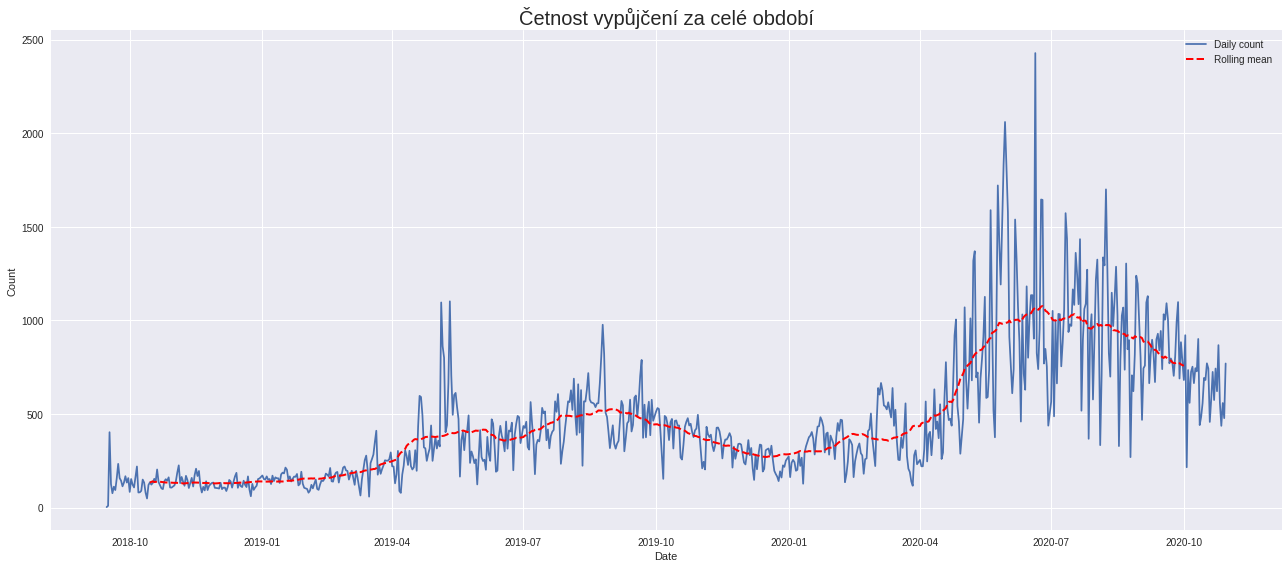

In [ ]:
#Vytvoření kopie a výběr pouze sloupce, který udavá datum a čas zapůjčení
eb_time = eb.copy()
eb_time = eb_time[['started_at']]

#Konvertování na pouhé datum a následná agregace
eb_time[['date']] = eb_time.started_at.dt.date
eb_time = eb_time.groupby('date').count()

#Přejmenování sloupce a vytvoření klouzavého průměru pro přehlednější vyhlazené zobrazení
eb_time.rename(columns = {'started_at' : 'count'}, inplace = True)
eb_time['rolling_mean'] = eb_time['count'].rolling(60, center=True).mean()

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.plot(eb_time.index, eb_time['count'], label='Daily count')
plt.plot(eb_time.index, eb_time['rolling_mean'], 'r--', linewidth = 2, label='Rolling mean')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení za celé období', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show();

**Z grafu lze vyčíst, že poptávka dlouhodobě roste. Nyní podrobněji rozebereme jednotlivé měsíce.**

**Vzhledem k tomu, že v tabulce se některé měsíce nacházejí vícekrát** *(záznamy jsou od 9/2018 do 10/2020)*  **, vydělil jsem četnost zápůjček počtem jednotlivých měsíců.**

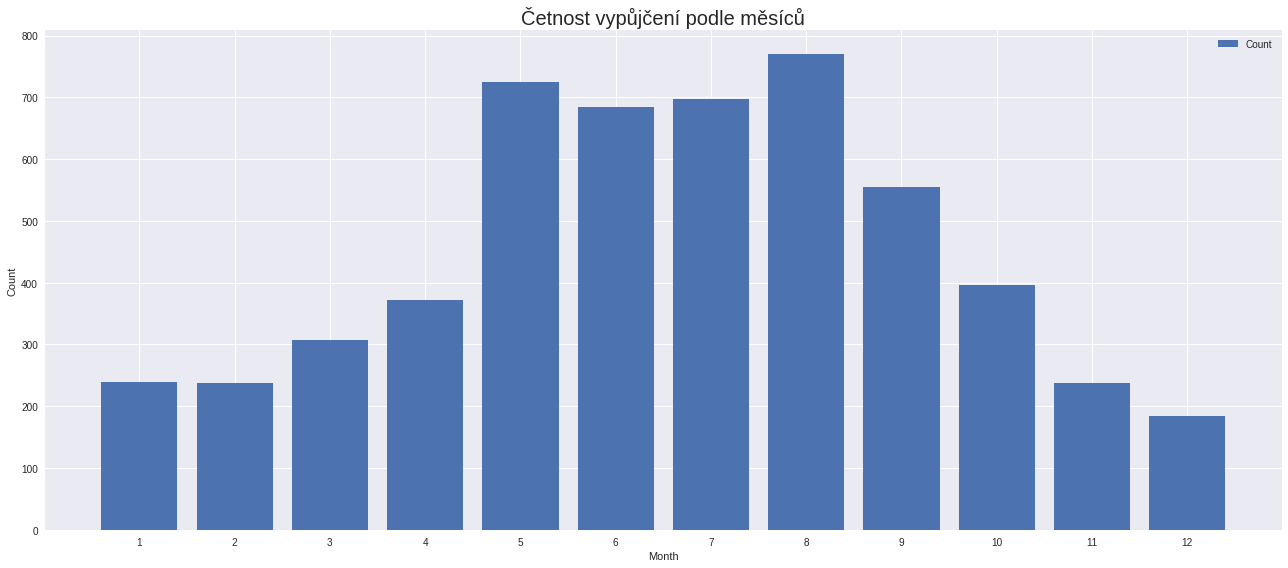

In [ ]:
#Úprava tabulky
eb_time_m = eb_time.reset_index()
eb_time_m['date'] = pd.to_datetime(eb_time_m.date)
eb_time_m['month'] = eb_time_m.date.dt.month
eb_time_m.drop('date', axis=1, inplace=True)

#Vytvoření počítadla a následná agregace
eb_time_m['count_month'] = 1
eb_time_m = eb_time_m.groupby('month').sum()

#Dělení počtem měsíců
eb_time_m['calculated_count'] = eb_time_m['count']/eb_time_m['count_month']
eb_time_m['calculated_count'] = eb_time_m['calculated_count'].round(0)

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.bar(eb_time_m.index, eb_time_m['calculated_count'], label='Count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení podle měsíců', fontsize=20)
plt.xticks(eb_time_m.index)
plt.grid(True)
plt.tight_layout()
plt.show();

**Neojoblíbenější období je od května do srpna.**

# **6. Příčiny výkyvů poptávky**

**Vliv počasí na četnosti.**

In [ ]:
#Vytvoření tabulky s časovými údaji
ebdf = eb[['started_at']]

#Separace data a času
ebdf['hours'] = ebdf.started_at.dt.hour
ebdf.started_at = ebdf.started_at.dt.date
ebdf['hours'] = pd.to_datetime(ebdf.hours, unit='h')
ebdf['hours'] = ebdf['hours'].dt.hour

#Agregace
ebdf['count'] = 1
ebdf.set_index('started_at', inplace=True)
ebdf = ebdf.groupby(['started_at', 'hours']).count().rename_axis(['date','time'])
ebdf.head(15)

count
date       time       
2018-09-15 8         1
           9         2
2018-09-16 12        8
           13        2
2018-09-17 8        10
           9        21
           10       35
           11       39
           12       32
           13       23
           14       22
           15       47
           16       54
           17       43
           18       34

In [ ]:
#Vytvoření tabulky o počasí
ewdf= ew.copy()

#Úprava indexů a datových typů
ewdf.date = pd.to_datetime(ewdf.date)
ewdf = ewdf.set_index(ewdf.date)
ewdf['time'] = pd.to_datetime(ewdf.time)
ewdf['time'] = ewdf['time'].dt.hour
ewdf = ewdf.set_index([ewdf.index, ewdf.time])
ewdf.drop(['date', 'time'], axis=1, inplace=True)
ewdf.head(16)

temp  feels              wind  ... cloud pressure        vis
date       time                                  ...                          
2018-09-01 0     11 °c  11 °c     9 km/h from S  ...   13%  1020 mb  Excellent
           3     13 °c  12 °c  11 km/h from SSW  ...   96%  1020 mb  Excellent
           6     14 °c  13 °c  11 km/h from SSW  ...  100%  1020 mb  Excellent
           9     14 °c  13 °c  14 km/h from SSW  ...   78%  1021 mb  Excellent
           12    16 °c  16 °c  15 km/h from SSW  ...   87%  1021 mb  Excellent
           15    17 °c  17 °c   14 km/h from SW  ...   97%  1021 mb  Excellent
           18    16 °c  16 °c   12 km/h from SW  ...   98%  1022 mb  Excellent
           21    14 °c  14 °c  11 km/h from SSW  ...   52%  1022 mb  Excellent
2018-09-02 0     13 °c  13 °c  10 km/h from SSW  ...   31%  1022 mb       Poor
           3     13 °c  13 °c   8 km/h from SSW  ...   52%  1020 mb       Poor
           6     14 °c  15 °c    5 km/h from SE  ...   67%  1020 mb       Poor
           9     19 °c  19 °c  18 km/h from SSW  ...   80%  1020 mb  Excellent
           12    20 °c  20 °c  21 km/h from SSW  ...   93%  1019 mb  Excellent
           15    19 °c  19 °c  19 km/h from SSW  ...   90%  1019 mb  Excellent
           18    18 °c  18 °c   12 km/h from SW  ...   70%  1019 mb  Excellent
           21    16 °c  16 °c  10 km/h from SSW  ...   82%  1020 mb       Poor

[16 rows x 9 columns]

In [ ]:
#Spojení záznamů o půjčkách a počasí
ebew = ewdf.join(ebdf).dropna()

#Seřazení dle nejvyšších četností
ebew.sort_values('count', ascending=False, inplace=True)
ebew.head(15)

temp  feels              wind  ... pressure        vis  count
date       time                                  ...                           
2020-06-20 12    19 °c  19 °c   12 km/h from SW  ...  1015 mb  Excellent  255.0
           15    20 °c  20 °c    17 km/h from S  ...  1013 mb  Excellent  222.0
2020-05-20 15    20 °c  20 °c  17 km/h from SSW  ...  1018 mb  Excellent  218.0
2020-06-06 15    14 °c  13 °c  14 km/h from ENE  ...   998 mb  Excellent  210.0
2020-05-30 12    20 °c  20 °c  16 km/h from ESE  ...  1026 mb  Excellent  208.0
2020-07-21 15    17 °c  17 °c    14 km/h from W  ...  1025 mb  Excellent  203.0
2020-05-25 12    18 °c  18 °c   23 km/h from SW  ...  1030 mb  Excellent  200.0
2020-05-30 15    19 °c  19 °c  18 km/h from ESE  ...  1025 mb  Excellent  197.0
2020-06-06 12    15 °c  13 °c   22 km/h from NE  ...   996 mb  Excellent  175.0
2020-05-29 15    23 °c  25 °c   6 km/h from ENE  ...  1026 mb  Excellent  174.0
2020-08-08 12    20 °c  20 °c    6 km/h from NE  ...  1025 mb  Excellent  174.0
2020-05-08 12    17 °c  17 °c  19 km/h from WSW  ...  1017 mb  Excellent  173.0
2020-05-20 18    17 °c  17 °c  15 km/h from SSW  ...  1017 mb  Excellent  165.0
2020-05-25 15    17 °c  17 °c   24 km/h from SW  ...  1030 mb  Excellent  165.0
2020-05-26 15    17 °c  17 °c    18 km/h from W  ...  1036 mb  Excellent  164.0

[15 rows x 10 columns]

**Graf níže ukazuje, že nejvíce výpůjček se uskuteční mezi 12 a 17°c.**

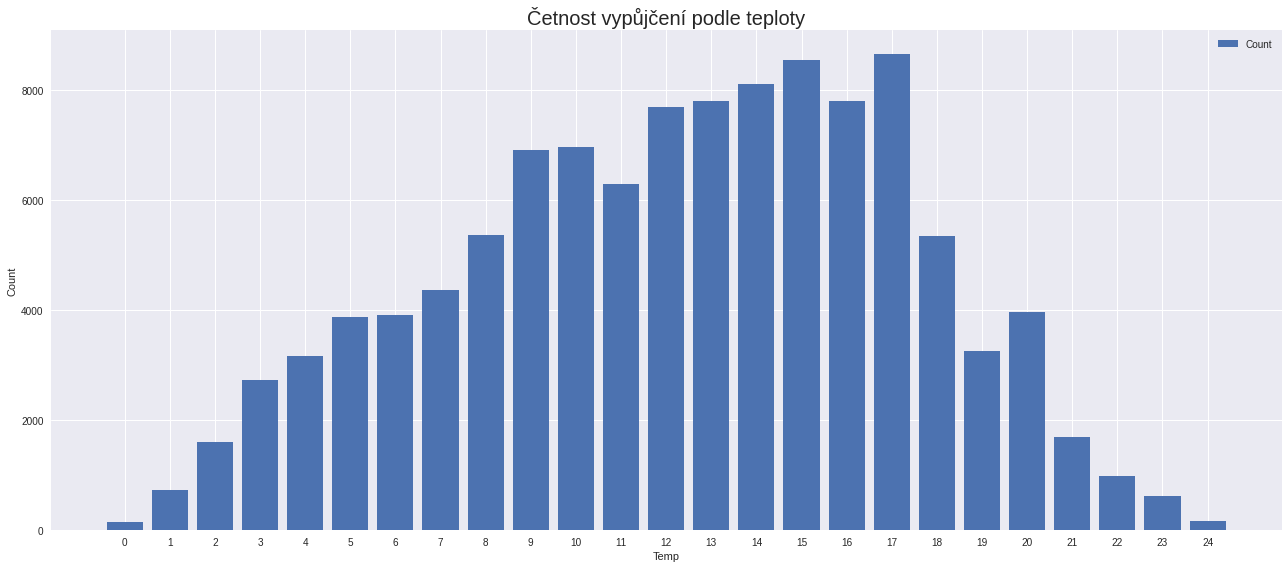

In [ ]:
#Příprava tabulky pro vizualizaci jednotlivých teplot
ebew_temp = ebew[['temp','count']]

#Odstranění nechtěných znaků (°c) a převod na int
ebew_temp.index = ebew_temp.temp.str.replace(r'\D', '').astype(int)

#Agregace
ebew_temp = ebew_temp.groupby(ebew_temp.index).sum()
ebew_temp.drop([26,27], axis=0, inplace=True)

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.bar(ebew_temp.index, ebew_temp['count'], label='Count')
plt.xlabel('Temp')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení podle teploty', fontsize=20)
plt.grid(True)
plt.xticks(ebew_temp.index)
plt.tight_layout()
plt.show();

**Ovšem pokud bychom chtěli zjistit nejoblíbenější teplotu pro vypůjčení, museli bychom vydělit počet výpůjček uskutečněných v určitou teplotu a počet dnů se stejnou teplotou. Jak je vidět na grafu níže, nejoblíbenější teplotou pro vypůjčení je 24°C.**

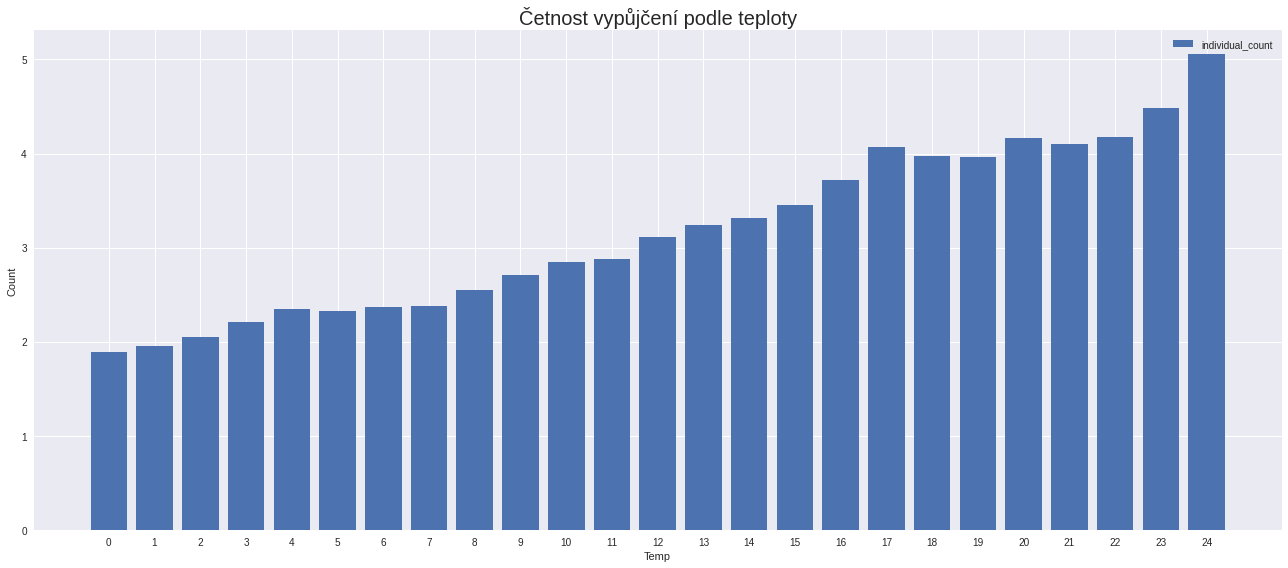

In [ ]:
#Příprava tabulky stejným postupem a vypočtení realné nejoblíbenější teploty
ebew_ind = ebew[['temp', 'count']]
ebew_ind['count_temp'] = 1
ebew_ind.reset_index(drop=True, inplace=True)
ebew_ind.index = ebew_ind.temp.str.replace(r'\D', '').astype(int)
ebew_ind = ebew_ind.groupby(ebew_ind.index).sum()
ebew_ind.drop([26,27], axis=0, inplace=True)
ebew_ind['individual_count'] = ebew_ind['count']/ebew_ind['count_temp']

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.bar(ebew_ind.index, np.log(ebew_ind['individual_count']), label='individual_count')
plt.xlabel('Temp')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení podle teploty', fontsize=20)
plt.grid(True)
plt.xticks(ebew_ind.index)
plt.tight_layout()
plt.show();

**Nejoblíbenější teplotou je tedy 24°c.**

**Stejným způsobem také analyzuji srážky. Na grafu níže vidíme, že srážky mají vliv na poptávku.**

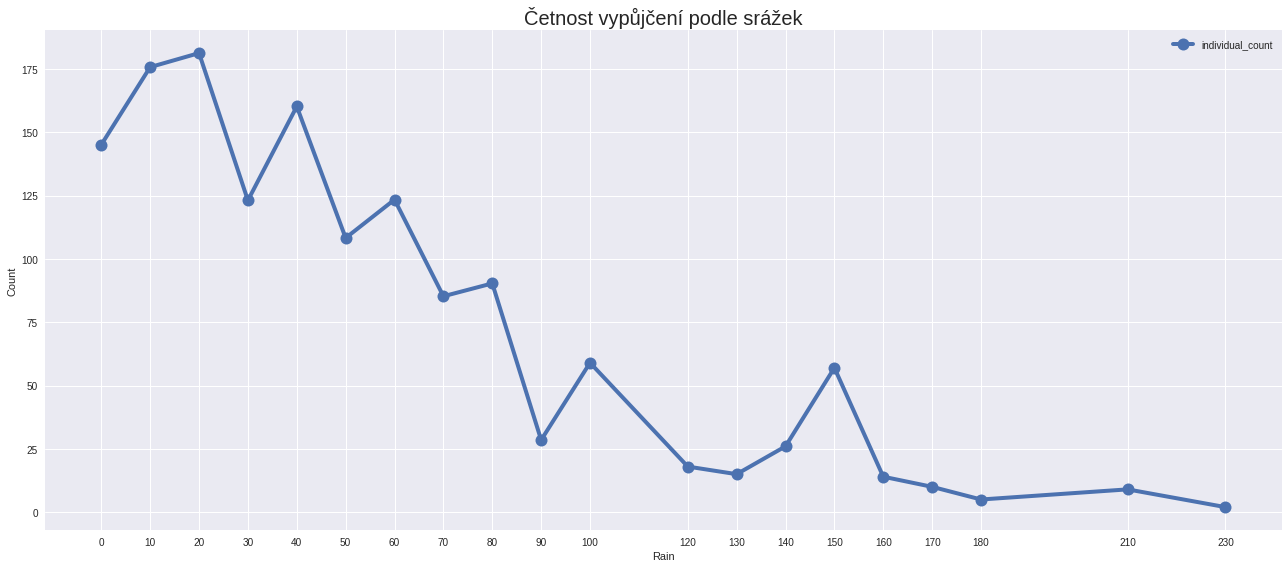

In [ ]:
#Příprava tabulky, stejný postup
rain = ebew[['rain', 'count']]
rain['rain'] = rain.rain.str.replace(r'\D', '').astype(float)
rain['count_rain'] = 1

#Agregace, výpočet, zaokrouhlení
rain = rain.groupby(rain.rain).sum()
rain['individual_count'] = rain['count']/rain['count_rain']
rain['individual_count'] = rain['individual_count'].round(2)
rain['rain'] = rain.index.astype(int)
rain.rain = rain.rain.round(-1)
rain.set_index(rain.rain, inplace=True)
rain = rain.groupby(rain.index).sum()
rain = rain[['individual_count']]

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.plot(rain.index, rain['individual_count'], label='individual_count', linewidth=4, marker='o', markersize=12)
plt.xlabel('Rain')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení podle srážek', fontsize=20)
plt.grid(True)
plt.xticks(rain.index)
plt.tight_layout()
plt.show();

**Nyní se podíváme, jaký vliv mají na poptávku dny v týdnu. Z grafu níže můžeme vyčíst, že nejvyšší zájem o vypůjčení je o víkendu, ovšem není to značný rozdíl.**

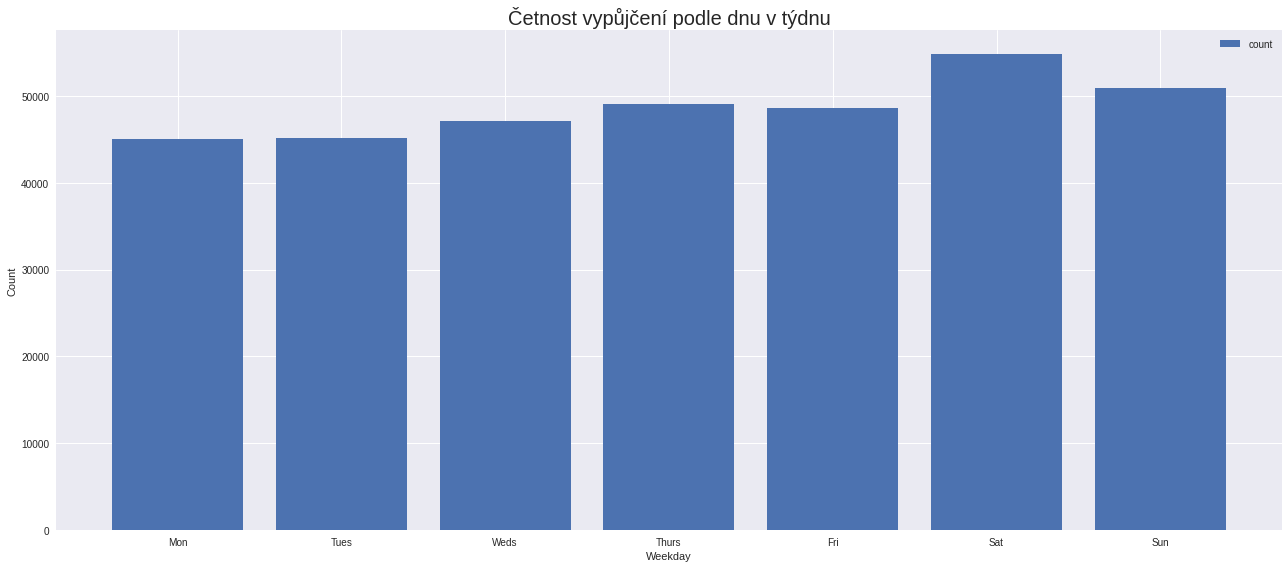

In [ ]:
#Vytvoření tabulky a editace
eb_weekend = eb_time.copy()
eb_weekend.reset_index(inplace=True)
eb_weekend['weekday'] = pd.to_datetime(eb_weekend['date']).dt.dayofweek.astype(str)
eb_weekend['weekday'].replace({'0': 'Mon', '1': 'Tues','2': 'Weds', '3': 'Thurs','4': 'Fri', '5': 'Sat','6': 'Sun'}, inplace=True)
eb_weekend = eb_weekend.groupby(eb_weekend.weekday).sum().reset_index()

#Uspořádání sloupců pro přehlednější vizualizaci
weekdays = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']
mapping = {day: i for i, day in enumerate(weekdays)}
key = eb_weekend['weekday'].map(mapping)    
eb_weekend = eb_weekend.iloc[key.argsort()]

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.bar(eb_weekend.weekday, eb_weekend['count'], label='count')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení podle dnu v týdnu', fontsize=20)
plt.grid(True)
plt.xticks(eb_weekend.weekday)
plt.tight_layout()
plt.show();

# **7. Odlehlé hodnoty**

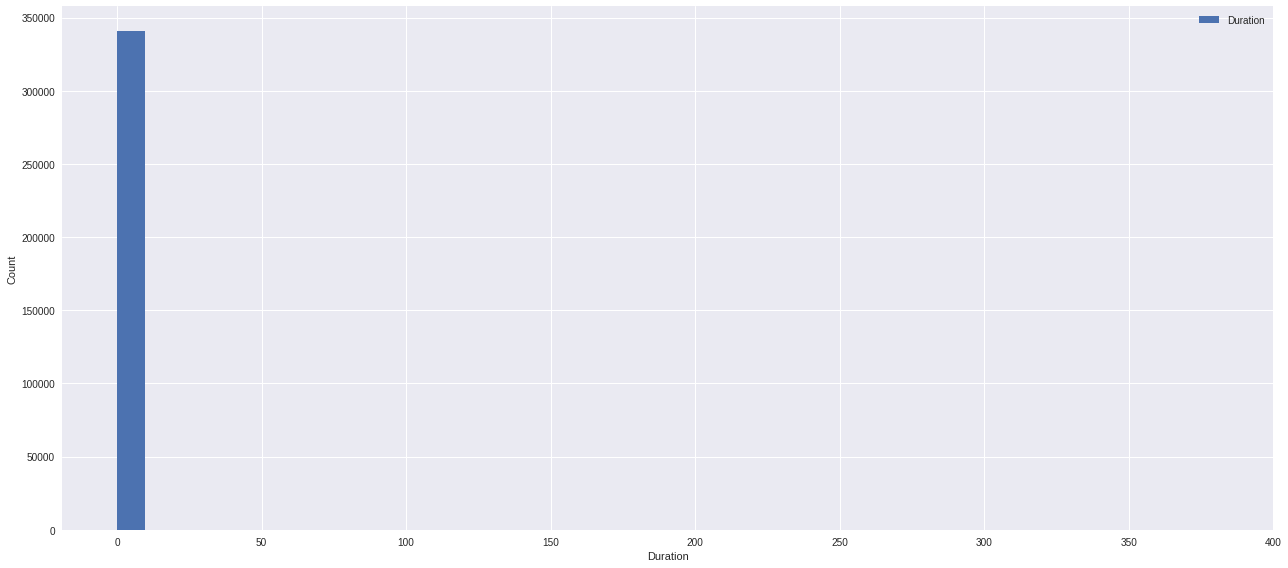

In [ ]:
#Vybrání sloupce doby trvání výpůjček
df_hist = eb[['duration']]

#Zaokrouhlení na hodiny
df_hist['duration'] = ((df_hist['duration']/60)/60).round(0)

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.style.use('seaborn')
plt.hist(df_hist['duration'], bins=40, label='Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

**Histogram nezobrazuje odlehlé hodnoty z důvodu jejich velmi nízké četnosti. Většina výpůjček trvá méně než hodinu**

# **8. Vliv rozmístění stanic na poptávku**

**Nyní analyzuji jaký vliv má umístěný stanice na četnost vypůjčení.**

In [ ]:
#Kopie tabulky obsahující souřadnice a editace
dff = coordinates_df
dff.rename(columns = {'start_station_name' : 'station', 'start_station_latitude' : 'latitude', 'start_station_longitude' : 'longitude', }, inplace = True)
dff = dff[['latitude', 'longitude']].round(4)

#Spojení s tabulkou obsahující četnosti zapůjčení a vyřazení neaktivních stanic
dff = dff.join(ssn, how='inner')
cond = dff['s_counts']>100
dff[cond]

,latitude,longitude,s_counts
Abbeyhill,55.9552,-3.1722,3360
Balgreen Road,55.9389,-3.2511,1772
Belford Road,55.9520,-3.2261,671
Boroughmuir,55.9401,-3.2153,2870
Borrowman Square,55.9826,-3.3815,544
...,...,...,...
Waverley Court,55.9517,-3.1842,676
Waverley Station,55.9526,-3.1875,442
West Crosscauseway,55.9439,-3.1850,2169
Wester Coates Terrace,55.9456,-3.2317,1310


**Na grafu níže můžeme vidět rozmístěný přeplněných a prázdných stanic. Z grafu se dá vyčíst, že většina zápujček se uskuteční v centru města, odkud lidé míří k pobřeží.**

**overfill = tmavá**

**missing = světlá**

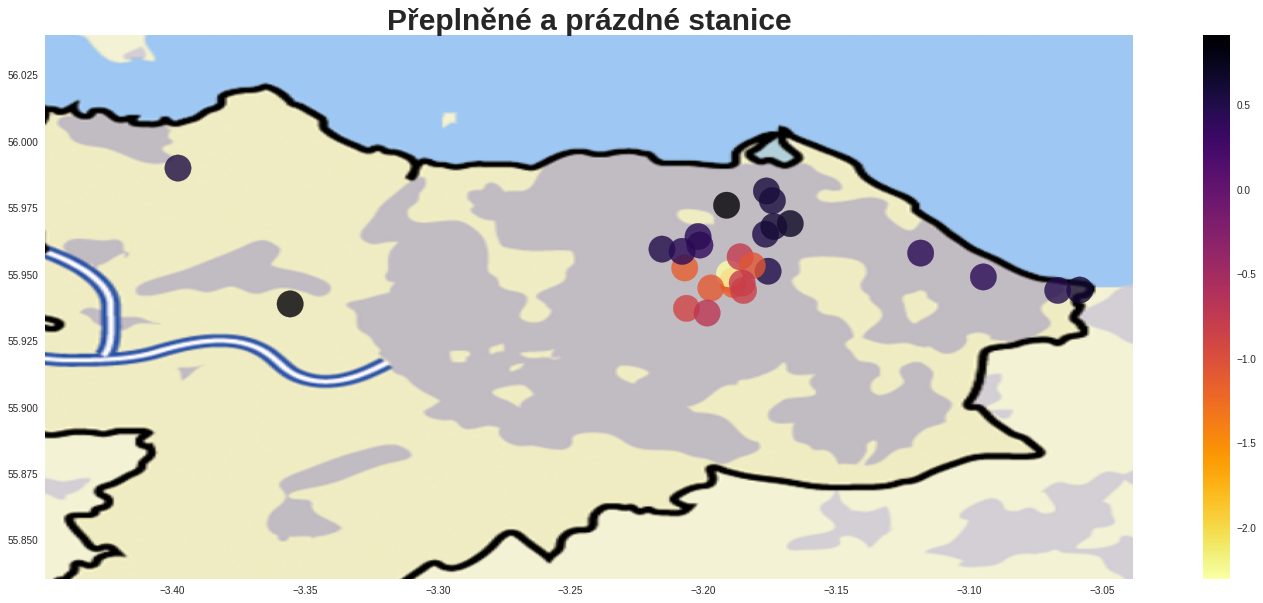

In [ ]:
#Vytvoření tabulky pomocí joinů
diff_df = coordinates_df.join(overfill)
diff_df = diff_df.join(missing)
diff_df = diff_df.dropna()
diff_df['diff'] = diff_df.overfill-diff_df.missing

#Stanovení podmínek pro vizualizaci
cond = diff_df['diff'] > 0.4
cond2 = diff_df['diff'] < -0.7

diff_df = diff_df[cond|cond2]

#Vytvoření GeoDataFramu
gdf3 = gpd.GeoDataFrame(diff_df, geometry=gpd.points_from_xy(diff_df.longitude, diff_df.latitude))

#Vytvoření grafu pomocí souřadnic
fig, ax = plt.subplots(figsize=(25,10))
ax.imshow(image, extent=[-3.525,-3.01, 55.8,56.07])
gdf3.plot(column='diff', ax=ax, cmap='inferno_r', legend=True, markersize=700, alpha=0.8)
plt.title('Přeplněné a prázdné stanice', fontsize=30,fontweight='bold')
plt.xlim(gdf3.longitude.min()-0.05,gdf3.longitude.max()+0.02)
plt.ylim( gdf3.latitude.min()-0.1,gdf3.latitude.max()+0.05)
plt.grid(False)
plt.show()

**Dále jsem vytvořil tabulku, která znázorňuje odkud kam lidé nejvíce jezdí. Dle tabulky se ukázalo, že u nejvyšších četností je startovní a konečná stanice totožná.**

In [ ]:
#Kopie tabulky se vzdálenostmi a editace nového DataFramu
df = df_dist.copy()
df2 = eb.set_index(['start_station_name', 'end_station_name'])
df2['count'] = 1
df2 = df2[['count']]

#Agregace
df2 = df2.groupby(level=[0,1]).count()
df = df.groupby(level=[0,1]).agg({'distance_km': 'first'})

#Spojení DataFramu
path_df = df2.join(df).fillna(0)
path_df.sort_values('count', ascending=False).head(30)

,,count,distance_km
start_station_name,end_station_name,,
Cramond Foreshore,Cramond Foreshore,2510,0.00
Portobello - Kings Road,Portobello - Kings Road,2431,0.00
Duke Street,Duke Street,2065,0.00
Portobello,Portobello,1778,0.00
Victoria Quay,Victoria Quay,1578,0.00
Canonmills,Canonmills,1477,0.00
Meadows East,Meadows East,1333,0.00
Ocean Terminal,Ocean Terminal,1296,0.00
Meadow Place,Meadow Place,1170,0.00


# **9. Návrhy na vylepšení služby a eliminace potenciálních problémů**

**Vytvořil jsem tabulku, která znázorňuje stanice, ve kterých kola chybí a přeplněné stanice, ze kterých se mohou kola dodávat. Mezi jednotlivými stanicemi jsem také přidal údaj o vzdálenosti, aby se kola mohla doplňovat co nejrychleji a nejefektivněji.**

**overfill > 1.3**

**missing > 1.3**

**distance_km < 5**

In [ ]:
#Spojení přeplněných a prázdných stanic
df_fill = df_dist.join(overfill, on='start_station_name')
df_fill = df_fill.join(missing, on='end_station_name')
df_fill.dropna(inplace=True)

#Nastavení indexů
df_fill.index.rename('overfill_station', level=0, inplace=True)
df_fill.index.rename('missing_station', level=1, inplace=True)
df_fill = df_fill.swaplevel()

#Stanovení podmínek
cond1 = df_fill.overfill>1.3
cond2 = df_fill.missing>1.3
cond3 = df_fill.distance_km<5
df_fill[cond1&cond2&cond3].sort_values(['missing'], ascending=False).head(30)

distance_km  overfill  missing
missing_station    overfill_station                                
City Chambers      Duke Street              3.29    1.4173   2.6784
                   Dudley Gardens           2.87    1.5553   2.6784
                   Victoria Quay            3.54    1.3296   2.6784
                   Ocean Terminal           3.79    1.3272   2.6784
Chambers Street    Dudley Gardens           3.16    1.5553   1.7343
                   Duke Street              3.37    1.4173   1.7343
                   Victoria Quay            3.71    1.3296   1.7343
Bristo Square      Dudley Gardens           3.33    1.5553   1.7339
                   Duke Street              3.52    1.4173   1.7339
                   Leith Walk North         2.99    1.3430   1.7339
                   Victoria Quay            3.86    1.3296   1.7339
                   Ocean Terminal           4.15    1.3272   1.7339
Charlotte Square   Duke Street              4.78    1.4173   1.7139
                   Leith Walk North         4.11    1.3430   1.7139
                   Ocean Terminal           4.69    1.3272   1.7139
                   Victoria Quay            4.62    1.3296   1.7139
                   Dudley Gardens           3.15    1.5553   1.7139
Lauriston Place    Ocean Terminal           4.67    1.3272   1.6935
                   Victoria Quay            4.46    1.3296   1.6935
                   Duke Street              4.27    1.4173   1.6935
St Andrews House   Ocean Terminal           3.18    1.3272   1.6703
                   Dudley Gardens           2.74    1.5553   1.6703
                   Victoria Quay            2.84    1.3296   1.6703
                   Duke Street              2.37    1.4173   1.6703
West Crosscauseway Duke Street              3.41    1.4173   1.4948
                   Ocean Terminal           4.26    1.3272   1.4948
                   Victoria Quay            3.93    1.3296   1.4948
                   Dudley Gardens           3.63    1.5553   1.4948
Picardy Place      Victoria Quay            2.70    1.3296   1.4528
                   Leith Walk North         1.89    1.3430   1.4528

**Díky následujícímu grafu, který znázorňuje počet zapůjčení v jednotlivých hodinách, se poté můžeme rozhodnout, v jakých hodinách budeme kola mezi jendotlivými stanicemi přesouvat.**

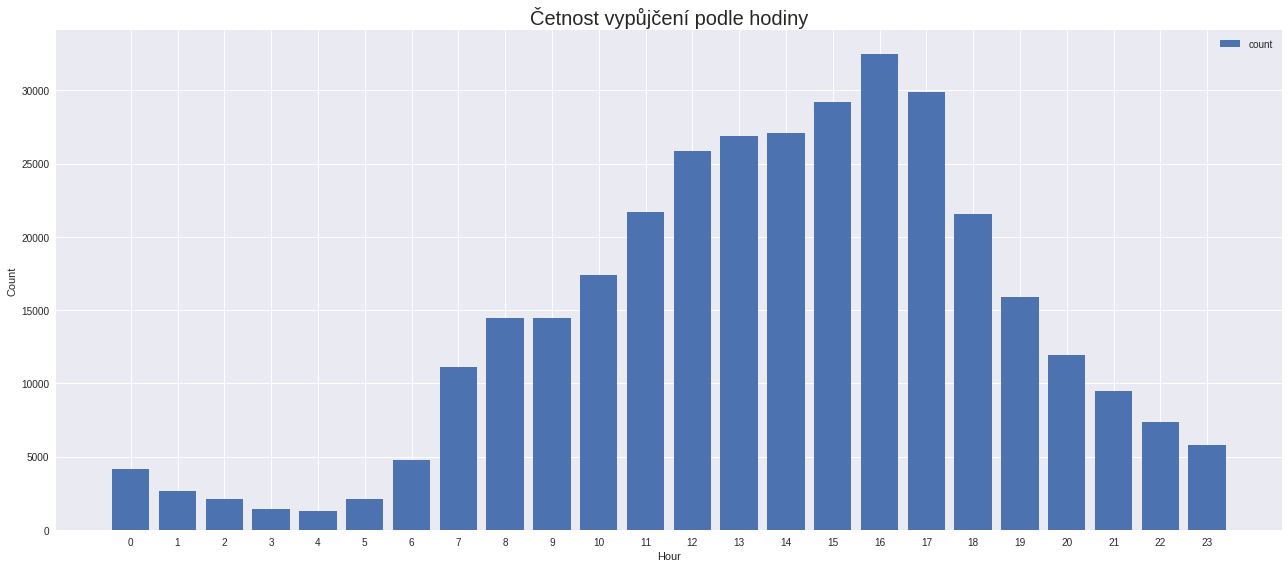

In [ ]:
#Převod časových údajů na hodiny
hours_df = eb[['started_at']]
hours_df['hour'] = eb['started_at'].dt.hour
hours_df['count'] = 1
hours_df.set_index(['hour'], inplace=True)
hours_df = hours_df.groupby('hour').count()
hours_df = hours_df.sort_values('hour')

#Tvorba grafu
plt.figure(figsize=(18,8))
plt.bar(hours_df.index, hours_df['count'], label='count')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend()
plt.title('Četnost vypůjčení podle hodiny', fontsize=20)
plt.grid(True)
plt.xticks(hours_df.index)
plt.tight_layout()
plt.show();

# **10. Závěr**

*   **Identifikoval jsem stanice, které jsou použity méně než 20x za rok a nejsou tedy nadále potřebné.**
*   **Zjistil jsem, že poptávka po kolech dlouhodobě roste a nejvyšší je mezi květnem a srpnem.**
*   **Identifikoval jsem příčiny výkyvů poptávky. Hlavními přičinami jsou teplota, srážky, roční období a čas. Menší nárůst můžeme zaznamenat o víkendech.**
*   **Zobrazil jsem odlehlé hodnoty pro dobu trvání jednotlivých výpůjček. Nejčastěji si lidé půjčují kola na méně než hodinu.**
*   **Zobrazil jsem pomocí grafu rozložení problematických stanic po městě. Díky tomu můžeme rozhodovat, kde bychom mohli přidat, nebo naopak ubrat počet stanic.**
*   **Zjistil jsem, ve kterých stanicích mohou kola chybět a doplnil údaje o tom, odkud tyto stanice nejefektivněji naplnit.**


